## Inception-CNN zur Klassifizierung von Bildern

Die Implementierung des hier vorgestellten, auf der Inception-Architektur basierenden Convolutional Neural Network hat zum Ziel die Klassifizierung zweier Datensätze zu übernehmen. Einerseits der "trauben" Datensatz, welcher aus Bildern von weißen und blauen Trauben besteht, andererseits der "lotr" Datensatz, der Bilder von Schauspielern aus den Herr der Ringe Filmen enthält. 

Da das Netzwerk für den Trauben-Datensatz bereits nach insgesamt 400 Iterationen konvergierte, wurde das Beispiel um einen zweiten Datensatz erweitert.

Die Grundidee dieses auf der Inception Architektur basierenden CNN basiert auf den von GoogLeNet eingeführten Inception Modulen, die mehrere parallele Convolutions ausführen und deren Feature-Maps mit dem Resultat eines Pooling-Layer konkatenieren. Weiterhin wurde die Idee des Verzichtes auf Fully-Connected Layer übernommen, um die Größe des Netzwerkes zu beschränken.

### Imports
Die für diese Implementierung benötigten Imports beinhalten:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # Darstellen von Bildern innerhalb des Notebook
import tensorflow as tf          # Die TensorFlow API
import numpy as np               # Konvertieren und Laden von Bildern
import time                      
from datetime import timedelta   # Zeitmessungen
import os                        # Laden von Bildpfaden, Bildern o.ä.

### Datensatz laden

Um das hier implementierte Inception-CNN erfolgreich trainieren zu können, wird ein Datensatz benötigt. Dazu wurde das in den TensorFlow Github Tutorials (Link hier!!!) verwendete dataset Modul verwendet, welches die Label anhand der Ordnerstruktur, in der die Bilder vorliegen kodiert. So kann beispielsweise der Trauben Datensatz mit sowohl Test- als auch Trainingsdaten komfortabel erstellt und geladen werden.

In [2]:
from dataset import load_cached

Die Funktion `load_dataset` lädt anhand des Parameters `name` den entsprechenden Datensatz, sofern dieser im Verzeichnis `./dataset/` liegt. Dieses `dataset` Objekt enthält nach dem Laden unter anderem die Anzahl der Klassen, sowie ein Array mit den Klassennamen des Datensatzes.

In [3]:
def load_dataset(name):
    dataset_name = name
    
    if(name == 'trauben'):
        cache_path = 'dataset/trauben.pkl'
        in_dir = 'dataset/trauben'
    
    else:
        cache_path = 'dataset/lotr.pkl'
        in_dir = 'dataset/lotr/'
    
    return load_cached(cache_path=cache_path, in_dir=in_dir)

Da im Verzeichnis `./dataset/` zwei Datensätze liegen, kann anhand des `dataset_names` Feldes entschieden werden, welcher Datensatz geladen werden soll. Die Funktion `load_dataset(name)` liefert anschließend den entsprechenden Datensatz zurück.

In [4]:
dataset_names = ['trauben', 'lotr']
dataset_name = dataset_names[0]

dataset = load_dataset(dataset_name)
num_classes, class_names = dataset.num_classes, dataset.class_names

Creating dataset from the files in: dataset/trauben
- Data loaded from cache-file: dataset/trauben.pkl


Da das `dataset` Modul nur die Pfade der Bilder und nicht die Bilder an sich lädt, wird eine weitere Hilfsfunktion benötigt. Diese Hilfsfunktion lädt die in `image_paths` enthaltenen Bilder in ein Feld und konvertiert diese Daten anschließend in Numpy Arrays.

In [5]:
from matplotlib.image import imread

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    #return np.asarray(images)
    return np.asarray(images)

Im folgenden werden die Trainings- bzw. Testdaten dem Datensatz entnommen und in entsprechende Felder aufgeteilt. Das Attribut `shape` eines Elementes des Numpy Arrays bestimmt hierbei die Breite, Höhe und auch Tiefe der Bilder innerhalb des Datensatzes, welche später für den Aufbau des Inception-CNN relevant sind. 

In [6]:
# train data
image_paths_train, cls_train, labels_train = dataset.get_training_set()
images_train = load_images(image_paths=image_paths_train)

# test data
image_paths_test, cls_test, labels_test = dataset.get_test_set()
images_test = load_images(image_paths=image_paths_test)

# setup for scaling
img_width, img_height, img_channels = images_train[0].shape

Nun kann getestet werden, ob die Test- und Trainingsdaten korrekt geladen wurden. An dieser Stelle könnte auch eine beispielhafte Ausgabe der Daten erfolgen, aber eine Ausgabe der Anzahl an Daten sollte genügen.

In [7]:
print("Datensatz:")
print(" - Training-set: \t{}".format(len(image_paths_train)))
print(" - Test-set: \t\t{}".format(len(image_paths_test)))

Datensatz:
 - Training-set: 	190
 - Test-set: 		20


### Benötigte Vars

Jedes künstliche neuronale Netzwerk braucht einen Input-Layer. Dieser Input-Layer ist in TensorFlow als "placeholder" Variable realisiert, welche durch einen Tensor (ein mehrdimensionales Array) repräsentiert und im folgenden als Platzhalter bezeichnet wird.

So können die Variablen `x`, als Platzhalter für den Input (Bilder), `y_true` als Platzhalter für ein Boolean-Feld über die vorhergesagte Klasse des Input und `y_true_cls` als Integer-Wert, der den Index der Klasse des Input in `class_names` abbildet definiert werden.

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_width, img_height, img_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

### Hilfsfunktionen zum Erstellen des Graphen

Folgend werden einige Variablen, sowie Hilfsfunktionen definiert, die für den Aufbau des Netzwerkes eine wichtige Rolle spielen und von verschiedenen, anderen Funktionen verwendet werden.

Die `size_NxN` Variablen dienen zum Definieren der Größe von Filtern innerhalb der Pooling- und Convolutional Layer. Die `moduleN_filter` definieren die Anzahl der verwendeten Filter innerhalb der Convolutional Layer des entsprechenden Inception Moduls. `dropout_rate` definiert die Rate, mit der bereits trainierte Gewichte von Neuronen zufällig entfernt werden. Dieses Vorgehen verhindert das so genannte "overfitting" des Netzes während des trainings.

In [9]:
# Filtergrößen für Convolution und Pooling
size_1x1 = [1,1]
size_2x2 = [2,2]
size_3x3 = [3,3]
size_5x5 = [5,5]

# Filter Anzahl der convolutions innerhalb Inception Modul
module1_filter = 64//2
module2_filter = 128//2
module3_filter = 256//2
module4_filter = 512//2

# Dropout rate für Training
dropout_rate = 0.4

Die Hilfsfunktion `conv2d` erstellt einen Convolutional Layer anhand der übergebenen Parameter und liefert den resultierenden Tensor als Ergebnis zurück.

Die Funktion dieser übergebenen Parameter ist wie folgt:
* `input`: Bestimmt den vorhergehenden Layer, also den Input der Convolution.
* `kernel`: Definiert die Größe jeder Convolution.
* `filter`: Definiert die Anzahl resultierender Feature-Maps.
* `name`: Bestimmt den Namen des Layer.
* `training`: Boolean-Attribut, welches indiziert ob die Variablen des Layer trainiert werden sollen.
* `strides`: Bestimmt den Abstand zwischen den einzelnen Convolutions, per default auf 1 gesetzt.

Das Auslagern der Erstellung eines Convolutional Layer dient in diesem Beispiel hauptsächlich der Lesbarkeit, bedingt durch die komplexe Architektur des Inception Modells.

In [10]:
def conv2d(input, filters, kernel, name, training, strides=1):
    return tf.layers.conv2d(inputs=input,
                            filters=filters,
                            kernel_size=kernel,
                            strides=strides,
                            padding='SAME',
                            name=name,
                            activation=tf.nn.relu,
                            use_bias=True,
                            trainable=training)

Die Hilfsfunktionen `max_pool` und `avg_pool` erstellen einen Pooling Layer anhand der definierten Parameter. Wie die Namen der Funktionen vermuten lassen, liefert `max_pool` hierbei einen Max-Pooling- und `avg_pool` einen Avg-Pooling Layer zurück.

Die übergebenen Parameter sind:
* `input`: Bestimmt den vorhergehenden Layer, also den Input des Pooling Schrittes.
* `size`: Definiert die Größe jeder Pooling Operation.
* `name`: Definiert den Namen des Layer für den TensorFlow Graphen.
* `strides`: Definiert den Abstand zwischen jeder Pooling Operation.

Wie auch bei der `conv2d` Hilfsfunktion dient das Auslagern des Erstellens der Pooling-Layer der Lesbarkeit innerhalb der Definition des Netzwerkes.

In [11]:
def max_pool(input, size, name, strides=1):
    return tf.layers.max_pooling2d(inputs=input,
                                   pool_size=size,
                                   strides=strides,
                                   padding='SAME',
                                   name=name)

In [12]:
def avg_pool(input, size, name, strides=1):
    return tf.layers.average_pooling2d(inputs=input,
                                       pool_size=size,
                                       strides=strides,
                                       padding='SAME',
                                       name=name)


Die Hilfsfunktion `flatten layer` dient der Anpassung der Dimensionalität eines Layers. Liegt z.B. ein Tensor der Form `[2 x 2 x 4]` vor, wird dieser in die Form `[1 x 1 x 16]` gebracht. Diese Konvertierung wird bei der Überführung der Hidden Layer in die Output Layer benötigt. 

In [13]:
def flatten_layer(input):
    shape = input.get_shape()
    features = shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, features])
    return layer_flat

Die Hilfsfunktion `inception_module` definiert ein neues Inception Modul. Dieses Inception Modul besteht hierbei aus ingesamt 5 Convolutional- und einem Pooling-Layer. Dabei wurde eine `5x5` Convolution durch zwei `3x3` Convolutions substituiert, sodass die resultierenden Feature-Maps zwar äquivalent, die Performanz jedoch verbessert wird. Weiterhin wird die `1x1` -> `3x3` Convolution parallel zu der `1x1` -> `3x3` -> `3x3` und dem `3x3` Pooling durchgeführt. Die Funktion der eingesetzten `1x1` Convolutions ist hierbei die Reduzierung der resultierenden Feature-Maps um die Gesamtzahl benötigter Parameter zu beschränken.

In [14]:
def inception_module(input_layer, num_filters, layer_index, training):
    # links
    conv_1x1_1 = conv2d(input_layer, num_filters//2, size_1x1, 'conv_1x1_1_{}'.format(layer_index), training)
    conv_3x3_1   = conv2d(conv_1x1_1, num_filters, size_3x3, 'conv_3x3_1_{}'.format(layer_index), training)
    
    # mitte
    conv_1x1_2 = conv2d(input_layer, num_filters//4, size_1x1, 'conv_1x1_2_{}'.format(layer_index), training)
    conv_3x3_2 = conv2d(conv_1x1_2, num_filters, size_3x3, 'conv_3x3_2_{}'.format(layer_index), training)
    conv_3x3_3 = conv2d(conv_3x3_2, num_filters, size_3x3, 'conv_3x3_3_{}'.format(layer_index), training)
    
    # rechts
    pool_3x3   = max_pool(input_layer, size_3x3, 'pool_3x3_{}'.format(layer_index))
    conv_1x1_3 = conv2d(pool_3x3, num_filters, size_1x1, 'conv_1x1_3_{}'.format(layer_index), training)
    
    return tf.nn.relu(tf.concat([conv_3x3_1, conv_3x3_3, conv_1x1_3], axis=3))

### Erstellen des TensorFlow Graphen

Um das Netzwerk trainieren bzw. evaluieren zu können, muss für die TensorFlow API ein TensorFlow Graph erstellt werden. Dieser Graph enthält alle Berechnungen des Netzwerkes, wobei eine Berechnung (z.B. Matritzenmultiplikation) als Knoten des Graphen abgebildet wird. Diese Darstellung des Netzwerkes, über einen Graphen, ermöglich eine effiziente Berechnung der zu verarbeitenden Daten. 

Die Funktion `inception_network` übernimmt hierbei die Aufgabe der Definition eines solchen Graphen. Als Parameter werden `images` - die Bilder, welche den Input für das Netzwerk darstellen, sowie `training` - ein Boolean-Wert, welcher indiziert ob die Variablen des Netzwerkes trainiert und optimiert werden sollen übergeben. 

Das hier definierte Netzwerk besteht aus ingesamt `4` Inception Modulen, welche über `inception_module` dem Graphen hinzugefügt werden und jeweils durch Max-Pooling Layer verknüpft sind. Diese Max-Pooling Layer reduzieren den Input im Verlauf des Graphen in so fern, dass die Breite und Höhe der Bilder mit jedem Inception + Pooling Layer abnimmt, die Anzahl der  Feature-Maps jedoch zunimmt. Diese Vorgehensweise wurde bei dem Entwurf der Inception-v3 Architektur etabliert und erwies sich in den an dieser Architektur durchgeführten Tests als gewinnbringend bezüglich der Fehlerrate von Erkennungen.

Weiterhin befindet sich unmittelbar nach den Inception Modulen ein Dropout-Layer mit einer dropout-rate von `dropout` , welcher zufällig Gewichte von bereits trainierten Neuronen entfernt um "overfitting" zu vermeiden und den Trainingsprozess zu beschleunigen. Der darauf folgende Softmax-Layer bildet den Output Layer des Netzwerkes und verknüpft den Output der aus den Inception Modulen entstanden ist, mit der Liste an möglichen Klassen.

In [15]:
def inception_network(images, training):
    # Form von images: [100 x 100 x 3]
    
    # Inception Modul 1 mit jeweils 32 Filtern
    inception_layer1 = inception_module(images, module1_filter, 0, training)
    # Resultat inception_layer1: [100 x 100 x 96]
    
    # Max-Pooling Layer 1 mit [2x2] Kernel und Strides 2
    maxpool1 = max_pool(inception_layer1, size_2x2, 'maxpool1', strides=2)
    # Resultat maxpool1: [50 x 50 x 96]
    
    # Inception Modul 2 mit jeweils 64 Filtern
    inception_layer2 = inception_module(maxpool1, module2_filter, 1, training)
    # Resultat inception_layer2: [50 x 50 x 192]
    
    # Max-Pooling Layer 2 mit [2x2] Kernel und Strides 2
    maxpool2 = max_pool(inception_layer2, size_2x2, 'maxpool3', strides=2)
    # Resultat maxpool2: [25 x 25 x 192]
    
    # Inception Modul 3 mit jeweils 128 Filtern
    inception_layer3 = inception_module(maxpool2, module3_filter, 2, training)
    # Resultat inception_layer3: [25 x 25 x 384]
    
    # Max-Pooling Layer 3 mit [5x5] Kernel und Strides 5
    maxpool3 = max_pool(inception_layer3, size_5x5, 'maxpool4', strides=5)
    # Resultat maxpool3: [5 x 5 x 384]
    
    # Inception Modul 4 mit jeweils 256 Filtern
    inception_layer4 = inception_module(maxpool3, module4_filter, 3, training)
    # Resultat inception_layer_4: [5 x 5 x 768]
    
    # Avg-Pooling Layer mit [5x5] Kernel und Strides 5
    avgpool = avg_pool(inception_layer4, size_5x5, 'pool', strides=5)
    # Resultat avgpool: [1 x 1 x 768]
    
    # Flat Layer, der avgpool konvertiert
    pool_flat = flatten_layer(avgpool)
    # Resultat pool_flat: [768]
    
    # Dropout Layer um "tote" Neuronen während des Trainings zu vermeiden
    dropout = tf.layers.dropout(inputs=pool_flat, rate=dropout_rate, training=training, name='dropout')

    # Linear Layer, der die extrahierten Feature-Maps auf num_classes abbildet
    linear = tf.layers.dense(inputs=dropout, units=num_classes, name='softmax')
    # Resultat linear: [10]
    
    # Softmax Aktivierungsfunktion für die Vorhersage der Klasse
    y_pred = tf.nn.softmax(linear)
    
    # Berechnung der Kreuz-Entropie als Verlustfunktion
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=linear, labels=y_true)
    
    # Berechnung des Verlust-Wertes
    loss = tf.reduce_mean(cross_entropy)
    
    # Klasse und Verlust-Wert zurück geben
    return y_pred, loss

Auf Grund der Lesbarkeit wird eine zusätliche Funktion `create_network` definiert, welche ein Boolean-Wert entgegennimmt, der bestimmt, ob die in diesem Netzwerk definierten Variablen trainierbar sind. Diese Funktion kapselt den Aufruf der Funktion `inception_network` in so fern, dass der Graph mit einem `variable_scope` versehen wird, sodass die trainierten Variablen auch für den Test des Netzwerkes verwendet werden können. Diese Funktion liefert die vorhergesagte Klasse, sowie den Verlust des aktuellen Trainingsschrittes zurück.

In [16]:
def create_network(training):
    # variable scope nutzen, um trainierte Variablen im Test wieder zu verwenden 
    with tf.variable_scope('network', reuse=not training):
        y_pred, loss = inception_network(images=x, training=training)

    return y_pred, loss

### Trainingsvariablen
Folgend werden einige Variablen, welche für das Training des Netzwerkes relevant sind definiert:

* `global_step`: Globale Zählvariable, welche die Trainingsschritte des Netzwerkes zählt.
* `loss`: Wert der Verlustfunktion im aktuellen Trainingsschritt.
* `optimizer`: Optimierungsfunktion, welche anhand des Verlustwertes die Variablen innerhalb des Netzwerkes optimiert.

In [17]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
# y_pred hier nicht benötigt, da Training
_, loss = create_network(training=True)
optimizer = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)

### Testvariablen
Folgende Variablen werden für das Testen des Netzwerkes benötigt:
* `y_pred`: Liste der Wahrscheinlichkeitsverteilung über die Klasse des Input.
* `y_pred_cls`: Index der vorhergesagten Klasse innerhalb des `class_names` Feldes.

In [18]:
# loss hier nicht benötigt, da Test
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Variablen zur Auswertung der Ergebnisse
Die folgenden Variablen werden zur Auswertung des Ergebnisses in sowohl Trainings- als auch Testphase benötigt:
* `correct_prediction`: Liste an Boolean-Werten, ob die vorhergesagte Klasse mit der tatsächlichen Klasse übereinstimmt. 
* `accuracy`: Mittelwert der Liste der in `correct_prediction` enthaltenen Werte. Die Boolean Werte werden dazu in einen Float-Wert konvertiert und anhand dieser Werte ein Mittelwert gebildet.

In [19]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Checkpoints
Damit das Netzwerk nicht jedes mal neu trainiert werden muss, wenn diese Anwendung ausgeführt wird, kann über die `tf.train.Saver` Klasse das Modell des trainierten Netzwerkes gespeichert werden. Dazu wird über das `os` Modul ggf. das Verzeichnis `save_dir` erstellt, in dem die Checkpoints gespeichert werden. Der Name des jeweiligen Checkpoints wird dabei durch die Zählvariable `global_step`, sowie die Variable `dataset_name` bestimmt.

Das von der Klasse `tf.Session()` Objekt, dient dazu `Tensor` Objekte zu evaluieren und kapselt somit die Knoten des TensorFlow Graphen als Operationen.

In [20]:
saver = tf.train.Saver(max_to_keep=1)
session = tf.Session()

save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, dataset_name)

Nun kann der Checkpoint (sofern dieser bereits existiert) geladen und die darin enthaltenen Variablen initialisiert werden. Sollte kein Checkpoint existieren, werden die in `create_network` definierten Variablen über `tf.global_variables_initializer()` initialisiert.

In [21]:
try:
    print("Versuche letzten Checkpoint zu laden ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Versuche die Variablen aus dem Checkpoint zu laden
    saver.restore(session, save_path=last_chk_path)
    print("Checkpoint geladen:", last_chk_path)

except:
    print("Checkpoint laden gescheitert, initialisiere Variablen")
    session.run(tf.global_variables_initializer())      

Versuche letzten Checkpoint zu laden ...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10-10000
Checkpoint laden gescheitert, initialisiere Variablen


### Trainieren
Der Trainingsprozess erfolgt anhand der im Datensatz definierten Trainingsdaten. Da dies unter Umständen sehr viel Arbeitsspeicher konsumieren kann, wird die Anzahl der in jedem Trainingsschritt verwendeten Daten durch `train_batch_size` limitiert. 
Die Funktion `random_batch` liefert dabei zufällig `train_batch_size` viele Trainingsdaten inkl. zugehöriger Label, sodass das Netwerk stückweise trainiert werden kann. 

In [22]:
train_batch_size = 8
def random_batch():
    num_images = len(images_train)
    
    idx = np.random.choice(num_images,
                          size=train_batch_size,
                          replace=False)
    
    x_batch = images_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

Die Funktion `optimize` übernimmt das eigentliche Training des Netzwerkes in `num_iterations` vielen Trainingsschritten. In jeder Iteration der `for` Schleife werden dabei `train_batch_size` viele Daten geladen und dem Netzwerk in Form eines `feed_dict` als Input übergeben. Dieses `feed_dict` ist ein Dictionary, welches die eingegebenen Daten mit dem jeweiligen Platzhalter verknüpft (Erinnerung: `x` ist der Platzhalter für die Bilddaten, `y_true` der Platzhalter für die zugehörigen Label).

Über das `Session` Objekt können anschließend die Berechnungen innerhalb des TensorFlow Graphen evaluiert werden. Das Übergeben der Parameter `global_step` und `optimizer` an das `Session` Objekt sorgt einerseits für das Inkrementieren der Zählvariable und andererseits für das Optimieren der Variablen innerhalb des Netzwerkes, für das jeweils eingegebene Bild.

Weiterhin wird alle `save_step` Iterationen ein Checkpoint des trainierten Modells erstellt und die in dieser Epoche (`save_step` viele Schritte bilden eine Epoche) erreichte Genauigkeit des Trainings ausgegeben.

In [23]:
def optimize(num_iterations, save_step):
    # Startzeit bestimmen
    start_time = time.time()
    
    # num_iterations oft:
    for i in range(num_iterations):
        # Trainingsdatensatz gestückelt von random_batch() erhalten
        x_batch, y_true_batch = random_batch()

        # feed_dict anhand des gestückelten Datensatzes erstellen
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # optimizer und global_step als Parameter der run Methode übergeben
        # und Berechnungen auf dem TensorFlow Graphen ausführen
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)
        
        # Alle save_step Iterationen:
        if (i_global % save_step == 0) or (i == num_iterations - 1):
            # Bestimme die Genauigkeit des Netzwerkes anhand der Trainingsdaten
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Status ausgeben
            print("Step: {0:>6}, Training Accuracy: {1:>6.1%}".format(i_global, batch_acc))

            # Modell speichern
            saver.save(session, save_path=save_path, global_step=global_step)
            print("Checkpoint gespeichert @ ", save_path)

    # Die Differenz zwischen Start- und Endzeit bestimmen und formatiert ausgeben
    time_dif = time.time() - start_time
    print("Benötigte Zeit: " + str(timedelta(seconds=int(round(time_dif)))))

Der Aufruf der Funktion `optimize` mit 1000 Iterationen und 10 Epochen.

In [24]:
if False:
    optimize(num_iterations=1000, save_step=100)

## Testen

Das Testen des Netzwerkes erfolgt anhand der Testdaten. Die Methode `predict` erhält dabei die drei Parameter `images`, `labels` und `classes` und berechnet die Vorhersage des trainierten Netzwerkes über die Klasse der über `images` übergebenen Bilder. Diese Bilder werden wie in `optimize` auch über ein `feed_dict` an das `Session` Objekt übergeben und mit Hilfe der Platzhalter Variablen `accuracy` und `y_pred_cls` die Genauigkeit der Erkennung sowie die Vorhergesagten Klassen bei der Auswertung des Graphen ermittelt.
Anschließend werden die Bilder mit ihrer zugehörigen Klasse, sowie der vorhergesagten Klasse über das `matplotlib` Modul ausgegeben.

In [25]:
def predict(images, labels, classes, print_images=True):
    assert len(images) == len(labels) == len(classes)
    
    feed_dict_test = {x: images, y_true: labels}
    acc, prediction = session.run([accuracy, y_pred_cls], feed_dict=feed_dict_test)
    
    print('Erreichte Genauigkeit des Datensatzes: {0:>6.1%}'.format(acc))
    
    if(print_images):
        length = len(images)
        fig, axes = plt.subplots(length//3, 3)

        fig.subplots_adjust(hspace=0.6, wspace=0.3)
        # über alle Achsen iterieren
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i])
            label = "Vorhersage:{1}\nTatsächlich:{0}".format(class_names[classes[i]], class_names[prediction[i]])
            ax.set_xlabel(label)

            # entferne Ticks, da kein Graph oder Diagramm
            ax.set_xticks([])
            ax.set_yticks([])

        # zeige Bild
        plt.show()

Folgend werden `num_tests` viele, zufällige Bilder aus den Testdaten ausgewählt und anschließend über die Funktion `predict` ausgewertet sowie ausgegeben.

Erreichte Genauigkeit des Datensatzes:  55.6%


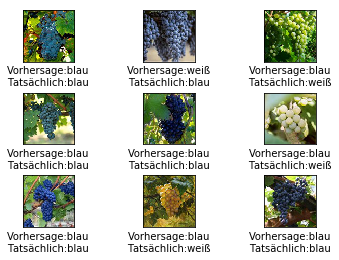

In [31]:
num_images = len(images_test)
num_tests = 9

idx = np.random.choice(num_images,
                       size=num_tests,
                       replace=False)

predict(images_test[idx], labels_test[idx], cls_test[idx], print_images=True)